### Ruben Abbou
## Approximation of a Primitive of a Function

We want to approximate $F(x) = \int_a^x f(s)ds$ using the Hermite cubic method, given a mesh $\sigma=\{a=x_0 < x_1 < \ldots < x_n =b\}$ and a tolerance. For each refinment $[c, d]$, we will accept the error $|f(x)-q(x)|$ to be within the tolerance at the points $\frac{3c+d}{4}$ and $\frac{c+d}{4}$.

In [1]:
import numpy as np
from numpy import sqrt, sin, pi, log
import matplotlib.pyplot as plt
from scipy.interpolate import CubicHermiteSpline

We approximate $f(s)$ on $[x_0, x_2]$ such that $f$ is exact at $x_0, x_2, x_1 = \frac{x_0+x_2}{2}$:

\begin{align*}
f(x) &= f(x_0)\phi_0(x) + f(x_1)\phi_1(x) + f(x_2)\phi_2(x) \\
&= f(x_0)\frac{(x-x_1)(x-x_2)}{(x_0-x_1)(x_0-x_2)} + f(x_1)\frac{(x-x_0)(x-x_2)}{(x_1-x_0)(x_1-x_2)} + f(x_2)\frac{(x-x_0)(x-x_1)}{(x_2-x_0)(x_2-x_1)}
\end{align*}
Therefore,

\begin{align*}
F(x) &= f(x_0)\int_a^x\phi_0(x)dx + f(x_1)\int_a^x\phi_1(x)dx + f(x_2)\int_a^x\phi_2(x)dx \\
&= f(x_0)\frac{x\left(\frac{x^2}{3} - x\cdot \frac{x_1+x_2}{2} + x_1x_2\right)}{(x_0-x_1)(x_0-x_2)} + f(x_1)\frac{x\left(\frac{x^2}{3} - x\cdot \frac{x_0+x_2}{2} + x_0x_2\right)}{(x_1-x_0)(x_1-x_2)} + f(x_2)\frac{x\left(\frac{x^2}{3} - x\cdot \frac{x_0+x_1}{2} + x_0x_1\right)}{(x_2-x_0)(x_2-x_1)}
\end{align*}


We can use these functions to evaluate the function $F$ using Cubic Hermite Splines.

In [2]:
def Hermite_cubic(sigma, f, tol, mesh, G, g, level=0):
    '''
    Method that takes a mesh and a function f and returns a data structure
    Inputs:
        - sigma: original given mesh
        - f: function
        - tol: tolerance
    Outputs:
        - mesh: refined mesh
        - g: evaluations of g at each point of the mesh
        - G: evaluations of G at each point of the mesh
    '''
    assert level < 31

    for i in range(len(sigma) - 1):
        x0 = sigma[i]
        x2 = sigma[i+1]
        x1 = (x0 + x2) / 2
        
        # calculate quadratic polynomial g for this interval
        phi_0 = lambda x: (x - x1) * (x - x2) / ((x0 - x1) * (x0 - x2))
        phi_1 = lambda x: (x - x0) * (x - x2) / ((x1 - x0) * (x1 - x2))
        phi_2 = lambda x: (x - x0) * (x - x1) / ((x2 - x0) * (x2 - x1))
        I = lambda x: f(x0) * phi_0(x) + f(x1) * phi_1(x) + f(x2) * phi_2(x)
        
        # calculate integral G of quadratic polynomial g
        fcn_0 = lambda x: x*(x**2/3 - x*(x1+x2)/2 + x1*x2) / ((x0 - x1) * (x0 - x2))
        fcn_1 = lambda x: x*(x**2/3 - x*(x0+x2)/2 + x0*x2) / ((x1 - x0) * (x1 - x2))
        fcn_2 = lambda x: x*(x**2/3 - x*(x0+x1)/2 + x0*x1) / ((x2 - x0) * (x2 - x1))
        int_I = lambda x: f(x0) * fcn_0(x) + f(x1) * fcn_1(x) + f(x2) * fcn_2(x)
                
        # make points to test precision
        p1 = (3 * x0 + x2) / 4
        p2 = (x0 + 3 * x2) / 4
        if level == 30 or (abs(f(p1) - I(p1)) <= tol and abs(f(p2) - I(p2)) <= tol):
            # good interval
            mesh.append(x2)
            G.append(int_I(x2) - int_I(x0) + G[-1])
            g.append(I(x2))
        else:
            # bad interval, do recursion
            mesh, G, g = Hermite_cubic([x0, x1, x2], f, tol, mesh, G, g, level+1)
    return mesh, G, g

In [3]:
def evaluate(G):
    '''
    Uses SciPy function to make cubic hermite function
    '''
    return CubicHermiteSpline(G[0], G[1], G[2])

In [4]:
def make_plots(sigma, f, tols = [1e-2, 1e-3, 1e-4]):
    '''
    Make plots of error and mesh
    Inputs:
        - sigma: original mesh
        - f: function
        - tols: list of tolerances to integrate the function on
    '''
    # we compute an exact result by evaluating our integral with a tolerance of 1e-6
    exact_spline = evaluate(Hermite_cubic(sigma, f, 1e-6, mesh=[sigma[0]], G = [0], g = [f(sigma[0])]))
    L = len(tols)
    fig = plt.figure(figsize=(L*7, 5))
    for i in range(L):
        # get interpolation of the integral before plotting
        cubic = Hermite_cubic(sigma, f, tols[i], mesh=[sigma[0]], G = [0], g = [f(sigma[0])])
        mesh = cubic[0]
        F = evaluate(cubic)
        x = np.linspace(sigma[0], sigma[-1], 1000)
        
        # plot
        plt.subplot(1, L, i+1)
        plt.plot(x[:-1], abs(F(x)-exact_spline(x))[:-1], 'r')
        plt.title("Approx error for tol = {} & mesh of len {}"\
                  .format(tols[i], len(mesh)))
        plt.xlabel("x")
        plt.ylabel("F(x)")
    plt.show()
    
    # plot mesh for 1e-4
    lengths = [mesh[i+1] - mesh[i] for i in range(len(mesh)-1)] \
                + [mesh[len(mesh)-1] - mesh[len(mesh)-2]]
    plt.step(mesh, log(lengths), 'b', where='post')
    plt.title("Interval length plot for tolerance = 1e-4")
    plt.ylabel('-log(good interval length)')
    plt.xlabel('x')
    plt.show()

## Case $f(x) = x^4$

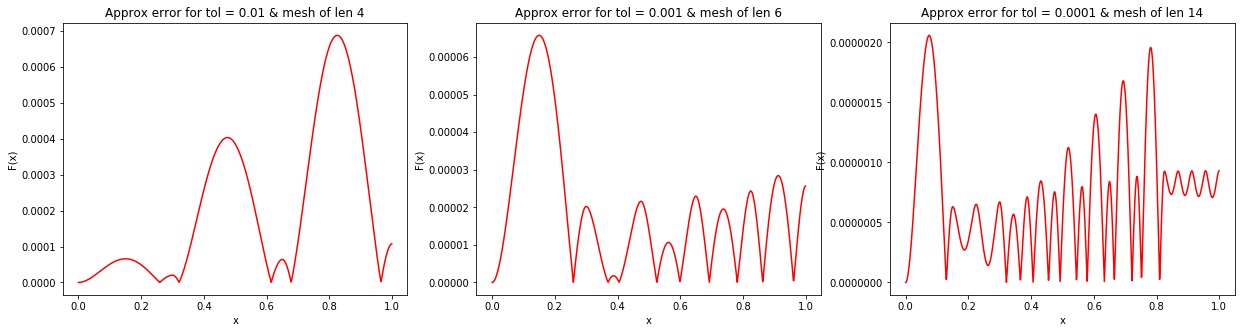

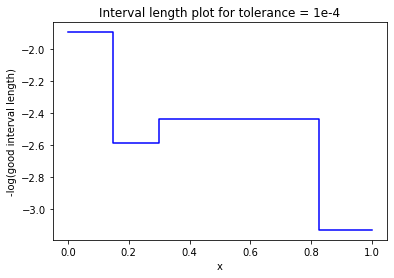

In [5]:
# Case 1
f = lambda x: x**4
sigma = [0, 0.3, 1.0]
make_plots(sigma, f)

## Case $f(x) = \sqrt{\sin(\pi x)}$

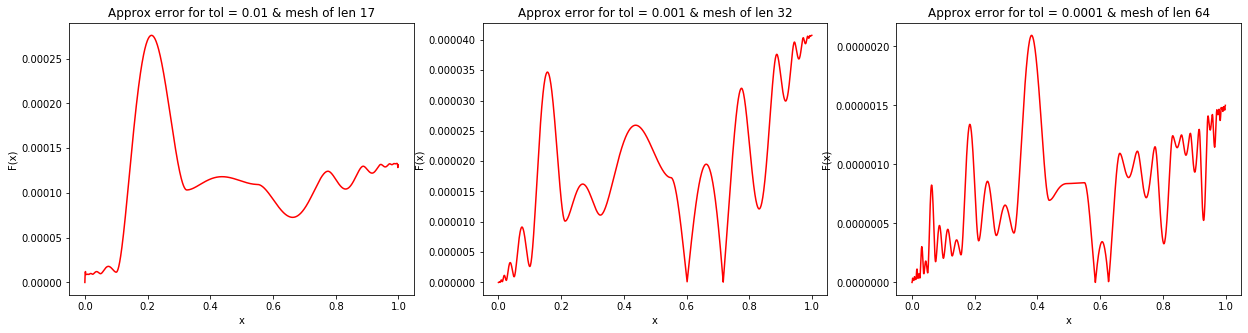

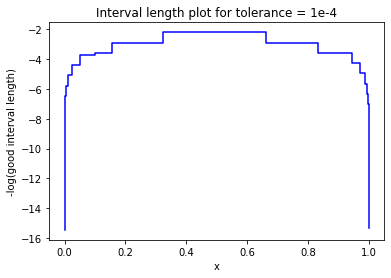

In [6]:
# Case 2
f = lambda x: sqrt(sin(pi*x))
sigma = [0, 0.1, 1.0]
make_plots(sigma, f)